In [115]:
import pandas as pd
import os
from numpy import mean, std
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [116]:
core_path = os.getcwd().replace("notebooks","artifacts")
values_path = os.path.join(core_path, "values.csv")

In [117]:
cols = pd.read_csv(values_path).columns

In [118]:
def load_dataset(file):
    data = pd.read_csv(file, header=None)
    dataset = data.values
    X = dataset[:, :-2]
    y = dataset[:,-1]
    return X, y

In [119]:
X, y = load_dataset(values_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [120]:
def select_features(X_train, y_train, X_test, score):
    fs = SelectKBest(score_func=score, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

## ANOVA f-test

In [121]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_classif)
out_dict = dict()
for i in range(len(fs.scores_)):
    # print('Feature %d: %f' % (i, fs.scores_[i]))
    out_dict[fs.scores_[i]] = cols[i]
print('f_classif')
for ix, i in enumerate(dict(sorted(out_dict.items(), reverse=True)).items()):
    print(f'{ix} > {i[0]}: {i[1]}')

f_classif
0 > 884.2275539820935: VV_Plus_VH
1 > 871.7026405670699: VV_Times_VH
2 > 775.715645523237: B8A
3 > 755.2612979426252: VH
4 > 742.2725780407549: B8
5 > 725.4121860745321: VV
6 > 703.9354018656819: MNDWI
7 > 642.5912114898453: VH_Times_VH
8 > 640.3757851589061: B7
9 > 636.2557394515495: NDTI
10 > 620.846649441348: VV_Times_VV
11 > 589.9910097400214: DI
12 > 579.5368618518706: B6
13 > 509.12001661193756: B11
14 > 499.3661339175354: NDVI
15 > 303.3137477335596: B12
16 > 226.6785730627858: B5
17 > 115.36961287538784: B4
18 > 112.48641377702468: NDBI
19 > 46.69236719613062: VH_VV_Ratio
20 > 24.22225541844213: B3
21 > 13.777782043804137: B2
22 > 4.705166748797874: VV_VH_Ratio
23 > 0.6854178341157883: EVI


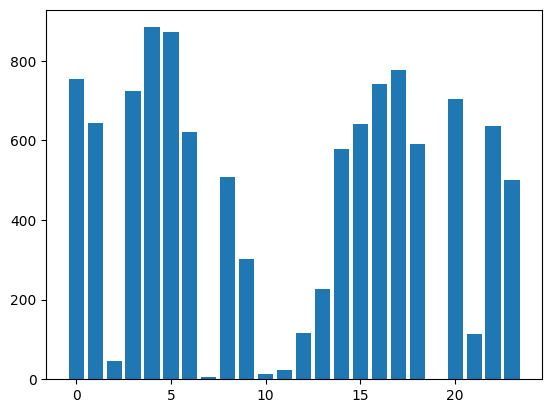

In [122]:
plt.bar(list(range(len(fs.scores_))), fs.scores_)
plt.show()

## Mutual Information

In [123]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_classif)
out_dict = dict()
for i in range(len(fs.scores_)):
    # print('Feature %d: %f' % (i, fs.scores_[i]))
    out_dict[fs.scores_[i]] = cols[i]
print('mutual_info_classif')
for ix, i in enumerate(dict(sorted(out_dict.items(), reverse=True)).items()):
    print(f'{ix} > {i[0]}: {i[1]}')

mutual_info_classif
0 > 0.47607910688853505: DI
1 > 0.47030915886887237: MNDWI
2 > 0.4505299771208222: B12
3 > 0.448372936328425: B11
4 > 0.4391165368415997: VV_Times_VH
5 > 0.43325411507812017: VH_Times_VH
6 > 0.42322445191546043: B8
7 > 0.42246564859891067: VV_Plus_VH
8 > 0.42119702755794064: VH
9 > 0.42103802798665746: B8A
10 > 0.41319341825646405: NDTI
11 > 0.4130464757323442: NDVI
12 > 0.4092141776140241: VV_Times_VV
13 > 0.3960621658138299: B7
14 > 0.3766445560829246: B6
15 > 0.37419090315975456: VV
16 > 0.3240704274752606: B5
17 > 0.22326783426270813: NDBI
18 > 0.2129069193150952: EVI
19 > 0.18286749900051502: B4
20 > 0.10033933391673444: B3
21 > 0.07922868275739492: B2
22 > 0.06046586540232113: VH_VV_Ratio
23 > 0.04271893802633464: VV_VH_Ratio


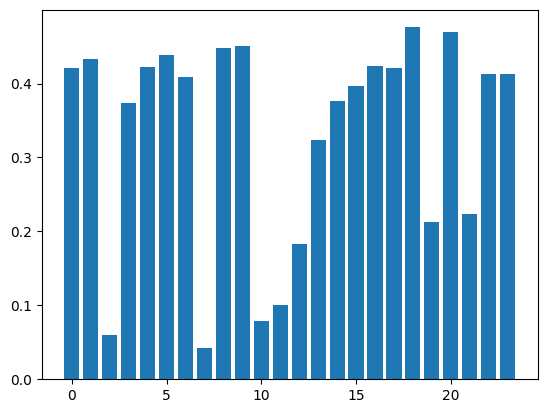

In [124]:
plt.bar(list(range(len(fs.scores_))), fs.scores_)
plt.show()

## GridSearchCV

In [125]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LogisticRegression(solver='liblinear')
fs = SelectKBest()#score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
grid['anova__score_func'] = [f_classif, mutual_info_classif]
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
results = search.fit(X[1:,:], y[1:])
print('Best Mean Accuracy: %.3f' % results.best_score_)
print(f'Best Config: {results.best_params_}')

Best Mean Accuracy: 0.958
Best Config: {'anova__k': 22, 'anova__score_func': <function f_classif at 0x000001992BDC1160>}


## score for each k-value and viz

In [126]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    return cross_val_score(
        model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise'
    )

In [127]:
num_features = [i+1 for i in range(X.shape[1])]

In [128]:
def run_evaluation(score_func, X, y):
    num_features = [i+1 for i in range(X.shape[1])]
    results = list()
    for k in num_features:
        model = LogisticRegression(solver='liblinear')
        fs = SelectKBest(score_func=score_func, k=k)
        pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
        scores = evaluate_model(pipeline, X, y)
        results.append(scores)
        print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
    return results

In [129]:
print('f_classif:')
results = run_evaluation(f_classif, X[1:,:], y[1:])

f_classif:


>1 0.904 (0.043)
>2 0.905 (0.036)
>3 0.927 (0.042)
>4 0.943 (0.029)
>5 0.940 (0.027)
>6 0.943 (0.028)
>7 0.946 (0.028)
>8 0.944 (0.028)
>9 0.945 (0.025)
>10 0.941 (0.028)
>11 0.942 (0.027)
>12 0.942 (0.026)
>13 0.942 (0.026)
>14 0.943 (0.029)
>15 0.943 (0.027)
>16 0.940 (0.026)
>17 0.941 (0.026)
>18 0.941 (0.027)
>19 0.942 (0.026)
>20 0.942 (0.026)
>21 0.955 (0.025)
>22 0.958 (0.024)
>23 0.958 (0.024)
>24 0.957 (0.023)


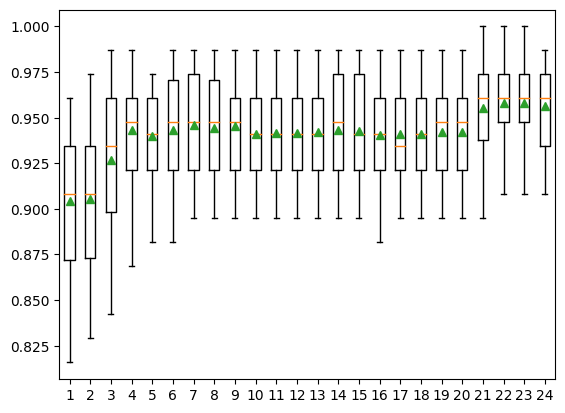

In [130]:
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

## Selection:
The following bands are being considered for the model even thought the scoring
system had given 22 features are required for max accuracy,

VV_Plus_VH,
VV_Times_VH,
B8,
MNDWI,
VH_Times_VH,
NDTI,
VV_Times_VV,
DI,
NDVI

some bands of S2 were neglected as they are of coarser resolution

NDBI is neglected based on EDA observations, water pixel values falling all over
the range and nonWater pixels are falling completely inside the water range.

Reference:

https://machinelearningmastery.com/feature-selection-with-numerical-input-data/#:~:text=The%20two%20most%20commonly%20used,and%20the%20mutual%20information%20statistic.